# 0. Instalacion de utilitarios Pyspark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [5]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 65kB/s 
     |████████████████████████████████| 204kB 43.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=e7c861d8539c0aa2c51ccea7e4a653752b4762ac7c43e20fd0385bc77ae189f2
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

# 1. Lectura del origen datos

In [0]:
# Lectura desde un archivo fisico

#from google.colab import files
#uploaded = files.upload()

In [7]:
# Conexion al drive
#---------------------------
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
ls

drive/        spark-2.3.4-bin-hadoop2.7/     spark-2.4.4-bin-hadoop2.7/
sample_data/  spark-2.3.4-bin-hadoop2.7.tgz  spark-2.4.4-bin-hadoop2.7.tgz


#2.  Cargando los datos en formato Spark

In [9]:
DS_Renovacion_prest = spark.read.csv('/content/drive/My Drive/UNALM/Training R ML en Casos de Negocios/2_caso negocio 2 riesgo crediticio/2_DS_creditos.csv', sep=',', header=True, inferSchema=True)

# 2.1 Revision de formatos 
DS_Renovacion_prest.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)



In [10]:
# 2.2 Revisiones  
DS_Renovacion_prest.show(5)

+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
| ID|Default|Prct_uso_tc|Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda|Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|Nro_dependiente|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
|  1|      1|0.766126609|  45|                     2|           0.802982129|               9120|                        13|                 0|                        6|                     0|              2|
|  2|      0|0.957151019|  40|                     0|           0.121876201|               2600|                         4|                 0|                        0|

In [11]:
# 2.3 Validacion de carga del total de registros (150,000 registros)
print(DS_Renovacion_prest.count())

150000


In [12]:
# 2.4 Exploracion inicial
DS_Renovacion_prest.describe().show()

# mean de Default: 0.06684

+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|summary|                ID|            Default|       Prct_uso_tc|              Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda| Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|   Nro_dependiente|
+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|  count|            150000|             150000|            150000|            150000|                150000|                150000|             150000|                    150000|             1500

# 3. Limpieza e imputacion de variables con valores vacios


In [13]:
# Proceso para identificar valores nulos en cada variables

from pyspark.sql.functions import col,sum

DS_Renovacion_prest.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in DS_Renovacion_prest.columns)).show()

DS_Renovacion_prest.select(*(sum(col(c).isNull().cast("int")/150000).alias(c) for c in DS_Renovacion_prest.columns)).show()


+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
| ID|Default|Prct_uso_tc|Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda|Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|Nro_dependiente|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
|  0|      0|          0|   0|                     0|                     0|                  0|                         0|                 0|                        0|                     0|              0|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+

In [24]:
# No se identificaron columnas con valores nulos

DS_Renovacion_prest.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)



In [0]:
# Limpiando de todos los valores nulos el data set
# DS_Renovacion_prest=DS_Renovacion_prest.na.drop()

# print(DS_Renovacion_prest.count())

In [43]:
# Revisamos cuando valores en cero

DS_Renovacion_prest.filter(DS_Renovacion_prest.Mto_ingreso_mensual == 0).count()

1634

In [44]:
DS_Renovacion_prest.filter(DS_Renovacion_prest.Mto_ingreso_mensual > 0).count()

118635

In [46]:
DS_Renovacion_prest.filter(DS_Renovacion_prest.Mto_ingreso_mensual == "NA").count()

29731

In [65]:
# borrador
# from pyspark.sql import functions as F
# DS = DS_Renovacion_prest.select("Mto_ingreso_mensual", F.when(DS_Renovacion_prest.Mto_ingreso_mensual > 0, DS_Renovacion_prest.Mto_ingreso_mensual).otherwise(0).alias("Mto_ingreso_mensual_2"))

# DS.show()

# Calculando la mediana
from pyspark.sql.types import FloatType

DS = DS_Renovacion_prest.filter(DS_Renovacion_prest.Mto_ingreso_mensual > 0)
DS = DS.withColumn("Mto_ingreso_mensual",DS["Mto_ingreso_mensual"].cast(FloatType()))

DS.approxQuantile("Mto_ingreso_mensual",[0.5],0.25)

[5400.0]

In [63]:
# Habilitamos las funciones de Pyspark, para reemplazar los "NA" o ceros es importante!

from pyspark.sql.functions import *

DS_Renovacion_prest = DS_Renovacion_prest.withColumn('Mto_ingreso_mensual', when(DS_Renovacion_prest.Mto_ingreso_mensual == "NA", 5400.0).otherwise(DS_Renovacion_prest.Mto_ingreso_mensual))

DS_Renovacion_prest = DS_Renovacion_prest.withColumn('Mto_ingreso_mensual', when(DS_Renovacion_prest.Mto_ingreso_mensual == 0, 5400.0).otherwise(DS_Renovacion_prest.Mto_ingreso_mensual))

#verificamos el reemplazamiento
DS_Renovacion_prest.describe().show()

+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|summary|                ID|            Default|       Prct_uso_tc|              Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda| Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|   Nro_dependiente|
+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|  count|            150000|             150000|            150000|            150000|                150000|                150000|             150000|                    150000|             1500

In [67]:
# Convirtiendo el tipo de dato de mto_ingreso_mensual

DS_Renovacion_prest = DS_Renovacion_prest.withColumn('Mto_ingreso_mensual_num',DS_Renovacion_prest["Mto_ingreso_mensual"].cast(FloatType()))

DS_Renovacion_prest.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)
 |-- Mto_ingreso_mensual_num: float (nullable = true)



In [69]:
DS_Renovacion_prest.groupBy("Nro_dependiente").count().show()

+---------------+-----+
|Nro_dependiente|count|
+---------------+-----+
|              7|   51|
|              3| 9483|
|              8|   24|
|              0|86902|
|             NA| 3924|
|              5|  746|
|              6|  158|
|              9|    5|
|              1|26316|
|             20|    1|
|             10|    5|
|              4| 2862|
|             13|    1|
|              2|19522|
+---------------+-----+



In [70]:
# Analizamos ahora el nro de dependientes

# Calculando la mediana
from pyspark.sql.types import FloatType

DS = DS_Renovacion_prest.filter(DS_Renovacion_prest.Nro_dependiente != 'NA')
DS = DS.withColumn("Nro_dependiente",DS["Nro_dependiente"].cast(FloatType()))

DS.approxQuantile("Nro_dependiente",[0.5],0.25)

[0.0]

In [71]:
# Reemplazamos el nro_dependiente
DS_Renovacion_prest = DS_Renovacion_prest.withColumn('Nro_dependiente', when(DS_Renovacion_prest.Nro_dependiente == 'NA', 0).otherwise(DS_Renovacion_prest.Nro_dependiente))

#verificamos el reemplazamiento
DS_Renovacion_prest.describe().show()

+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+-----------------------+
|summary|                ID|            Default|       Prct_uso_tc|              Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda| Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|   Nro_dependiente|Mto_ingreso_mensual_num|
+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+-----------------------+
|  count|            150000|             150000|            150000|            150000|                150000|               

In [74]:
# Convirtiendo el tipo de dato de Nro_dependiente

from pyspark.sql.types import IntegerType

DS_Renovacion_prest = DS_Renovacion_prest.withColumn('Nro_dependiente_num',DS_Renovacion_prest["Nro_dependiente"].cast(IntegerType()))

DS_Renovacion_prest.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)
 |-- Mto_ingreso_mensual_num: float (nullable = true)
 |-- Nro_dependiente_num: integer (nullable = true)



In [88]:
DS_Renovacion_prest.groupBy("Nro_prestao_retrasados").count().show()

+----------------------+------+
|Nro_prestao_retrasados| count|
+----------------------+------+
|                    12|     2|
|                     1| 16033|
|                    13|     1|
|                     6|   140|
|                     3|  1754|
|                    96|     5|
|                     5|   342|
|                     9|    12|
|                     4|   747|
|                     8|    25|
|                     7|    54|
|                    10|     4|
|                    98|   264|
|                    11|     1|
|                     2|  4598|
|                     0|126018|
+----------------------+------+



# 4. Exploracion de datos

In [75]:
#4.2 Variable objetivo

print(DS_Renovacion_prest.count())
DS_Renovacion_prest.groupBy('Default').count().show()

# % en Default (10,026/150000) = 0.06684

150000
+-------+------+
|Default| count|
+-------+------+
|      1| 10026|
|      0|139974|
+-------+------+



# 5. Analisis de relevancia del cliente automatizada (Information Value)

In [76]:
!pip install scorecardpy

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.1.1-cp36-none-any.whl size=58169 sha256=ce86a4baea2c9c1dbe48798c2edab8c8786a5fe9b124253ab3e1baa8102450c5
  Stored in directory: /root/.cache/pip/wheels/8f/4c/98/567ff70984acd88ffae211d8fc209e34b98fb43ff27f09fdd3
Successfully built scorecardpy


In [0]:
import scorecardpy as sc
import pandas as pd

In [79]:
type(DS_Renovacion_prest)

pyspark.sql.dataframe.DataFrame

In [0]:
DS_Renovacion_prest = DS_Renovacion_prest.drop("ID","Mto_ingreso_mensual","Nro_dependiente")

In [0]:
df = DS_Renovacion_prest.toPandas()

In [82]:
type(df)

pandas.core.frame.DataFrame

In [83]:
# Formato de variables ScorecardPy
dt_s = sc.var_filter(df, y="Default")

[INFO] filtering variables ...
Variable filtering on 150000 rows and 11 columns in 00:05:50 
0 variables are removed


In [84]:
#Ranking de Variables
sc.iv(df, y="Default")

,variable,info_value
7,Nro_retraso_60dias,0.881208
4,Mto_ingreso_mensual_num,0.835795
6,Nro_prestao_retrasados,0.761158
8,Nro_retraso_ultm3anios,0.601024
1,Prct_deuda_vs_ingresos,0.406449
0,Prct_uso_tc,0.307700
5,Edad,0.274367
9,Nro_prod_financieros_deuda,0.116379
3,Nro_creditos_hipotecarios,0.068348
2,Nro_dependiente_num,0.035484


In [86]:
bins = sc.woebin(dt_s, y="Default")

[INFO] creating woe binning ...
Binning on 150000 rows and 11 columns in 00:00:14


{'Edad': <Figure size 432x288 with 2 Axes>,
 'Mto_ingreso_mensual_num': <Figure size 432x288 with 2 Axes>,
 'Nro_creditos_hipotecarios': <Figure size 432x288 with 2 Axes>,
 'Nro_dependiente_num': <Figure size 432x288 with 2 Axes>,
 'Nro_prestao_retrasados': <Figure size 432x288 with 2 Axes>,
 'Nro_prod_financieros_deuda': <Figure size 432x288 with 2 Axes>,
 'Nro_retraso_60dias': <Figure size 432x288 with 2 Axes>,
 'Nro_retraso_ultm3anios': <Figure size 432x288 with 2 Axes>,
 'Prct_deuda_vs_ingresos': <Figure size 432x288 with 2 Axes>,
 'Prct_uso_tc': <Figure size 432x288 with 2 Axes>}

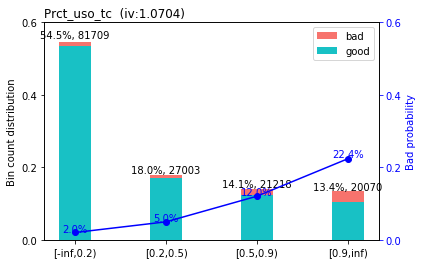

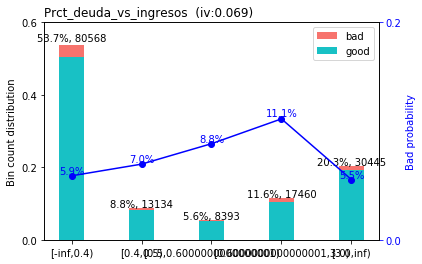

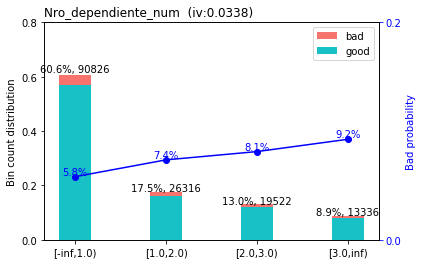

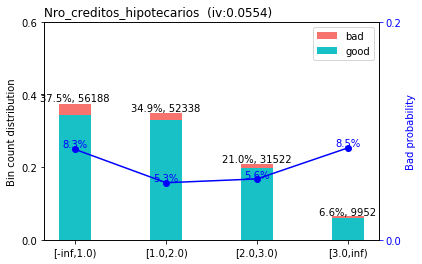

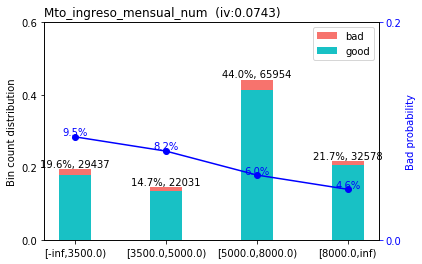

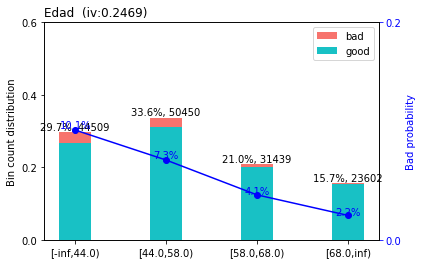

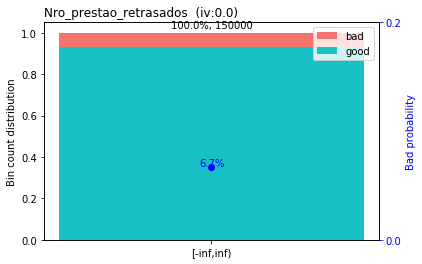

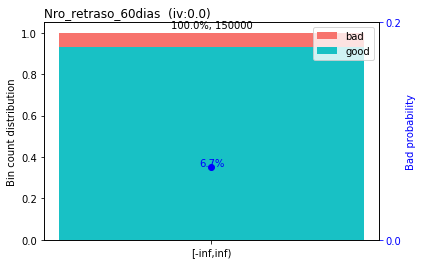

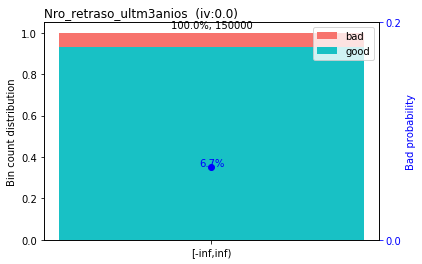

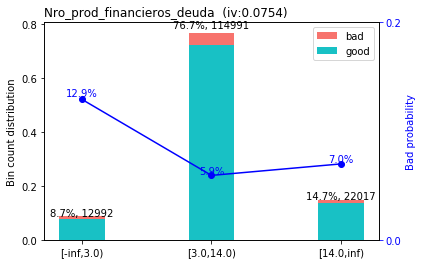

In [87]:
sc.woebin_plot(bins)

In [0]:
# training_df,test_df = model_df_Renovacion_prest.randomSplit([0.7,0.3],seed=1234)

# 5. Relevancia y transformacion de variables 

In [0]:
# No hay necesidad de convertir variables de tipo categoria a numericas porque no hay

# StringIndexer> Crea columnas por valor distinto de una variable categorica

# Metodo de transformacion: Generando valores por cada categoria
#----------------------------------------------------
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import VectorAssembler  

# Transformacion
# region_indexer = StringIndexer(inputCol="REGION", outputCol="REGION_Numerico").fit(DS_Renovacion_prest)

# DS_Renovacion_prest = region_indexer.transform(DS_Renovacion_prest)

# DS_Renovacion_prest.show(5,False)


In [0]:
##############################################  A PARTIR DE AQUI PROBAMOS DISTINTAS COMBINACIONES #############################################

# Consolidacion de variables

# ESCENARIO 1: 

# Correr esta parte si la columna features ya existe
# DS_Renovacion_prest = DS_Renovacion_prest.drop("features")

df_assembler = VectorAssembler(inputCols=['Nro_retraso_60dias','Mto_ingreso_mensual_num','Nro_prestao_retrasados','Nro_retraso_ultm3anios','Prct_deuda_vs_ingresos'], outputCol="features")

DS_Renovacion_prest = df_assembler.transform(DS_Renovacion_prest)

In [92]:
#Revision

#DS_Renovacion_prest.printSchema()
DS_Renovacion_prest.select('Default','features').show(3,False)

+-------+--------------------------------+
|Default|features                        |
+-------+--------------------------------+
|1      |[0.0,9120.0,2.0,0.0,0.802982129]|
|0      |(5,[1,4],[2600.0,0.121876201])  |
|0      |[1.0,3042.0,1.0,0.0,0.085113375]|
+-------+--------------------------------+
only showing top 3 rows



In [0]:
#Matriz de Modelamiento
model_df_Renovacion_prest=DS_Renovacion_prest.select('Default','features')

# 6. Entrenamiento del Algoritmo (Regresion Logistica)

In [94]:
# Definicion de muestra de entrenamiento y Validacion

training_df,test_df = model_df_Renovacion_prest.randomSplit([0.7,0.3],seed=1234)

# Tamaño de muestra
print(training_df.count(),test_df.count())


105251 44749


In [95]:
training_df.describe().show()

+-------+-------------------+
|summary|            Default|
+-------+-------------------+
|  count|             105251|
|   mean|0.06750529686178754|
| stddev| 0.2508962531432095|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [96]:
test_df.describe().show()

+-------+-------------------+
|summary|            Default|
+-------+-------------------+
|  count|              44749|
|   mean|0.06527520168048448|
| stddev|0.24701358917304803|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [0]:
# Modelamiento de Regresion Logistica

from pyspark.ml.classification import LogisticRegression

log_reg=LogisticRegression(maxIter = 10,labelCol='Default').fit(training_df)

In [98]:
# Revision
log_reg.coefficients

DenseVector([0.1512, -0.0001, 0.5122, -0.6144, -0.0])

In [100]:
# Aplicando sobre la data Train el modelo identificado

train_results=log_reg.evaluate(training_df).predictions


# Verificando las probabilidad en los clientes con compra

train_results.filter(train_results['Default']==1).select(['Default','prediction','probability']).show(10,False)

+-------+----------+----------------------------------------+
|Default|prediction|probability                             |
+-------+----------+----------------------------------------+
|1      |0.0       |[0.8949392426927285,0.10506075730727145]|
|1      |0.0       |[0.8955265171350282,0.10447348286497175]|
|1      |0.0       |[0.8976241762660188,0.10237582373398121]|
|1      |0.0       |[0.89912706128505,0.10087293871494998]  |
|1      |0.0       |[0.9030599696378113,0.09694003036218873]|
|1      |0.0       |[0.9039930971588916,0.0960069028411083] |
|1      |0.0       |[0.904465370975623,0.09553462902437701] |
|1      |0.0       |[0.9068810129152935,0.09311898708470649]|
|1      |0.0       |[0.9082366471638027,0.09176335283619726]|
|1      |0.0       |[0.9092833647836006,0.09071663521639942]|
+-------+----------+----------------------------------------+
only showing top 10 rows



# 7. Evaluacion de poder predictivo

In [0]:
# Aplicando el modelo predictivo

transformed = log_reg.transform(test_df)

In [102]:
test_df.show(5)

+-------+--------------------+
|Default|            features|
+-------+--------------------+
|      0| (5,[0,1],[1.0,1.0])|
|      0|(5,[0,1],[1.0,197...|
|      0|(5,[0,1],[1.0,770...|
|      0|(5,[0,1],[1.0,142...|
|      0|(5,[0,1],[1.0,200...|
+-------+--------------------+
only showing top 5 rows



In [103]:
# Revision
transformed.show(3,False)

+-------+---------------------+----------------------------------------+----------------------------------------+----------+
|Default|features             |rawPrediction                           |probability                             |prediction|
+-------+---------------------+----------------------------------------+----------------------------------------+----------+
|0      |(5,[0,1],[1.0,1.0])  |[2.0702093082944244,-2.0702093082944244]|[0.887973784357498,0.11202621564250208] |0.0       |
|0      |(5,[0,1],[1.0,197.0])|[2.090003850963119,-2.090003850963119]  |[0.889927802864195,0.11007219713580506] |0.0       |
|0      |(5,[0,1],[1.0,770.0])|[2.147872590499659,-2.147872590499659]  |[0.8954698111026177,0.10453018889738235]|0.0       |
+-------+---------------------+----------------------------------------+----------------------------------------+----------+
only showing top 3 rows



In [108]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'Default'])

from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc_2 = SparkContext.getOrCreate()
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc_2.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

The ROC score is (@numTrees=200):  0.657352785475099


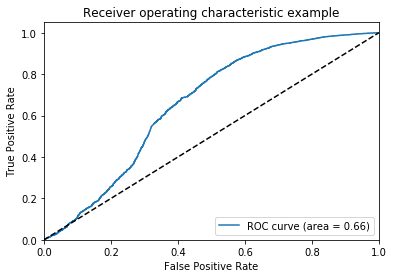

In [107]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [109]:
train_results.stat.crosstab("Default", "prediction").show()

+------------------+-----+---+
|Default_prediction|  0.0|1.0|
+------------------+-----+---+
|                 1| 6924|181|
|                 0|97983|163|
+------------------+-----+---+



#8. Aplicacion de modelos adicionales

In [0]:
# Conviene consolidar modelos cuando las probabilidades que arrojan los modelos NO estan correlacionadas... Ensamble

##8.1 Algoritmo de Arbol de Clasficacion

In [0]:
# Arbol de clasificacion

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="FLAG_VENTA")
dt_model = dt.fit(training_df)

dt_prediction = dt_model.transform(test_df)

dt_prediction.select("prediction", "FLAG_VENTA", "features").show()

In [0]:
# Reglas del arbol
#print(dt_model.toDebugString)

In [0]:
# Evaluacion del poder predictivo del arbol
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="FLAG_VENTA", predictionCol="prediction", metricName="accuracy")

dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))


In [0]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = dt_prediction.select(['probability', 'FLAG_VENTA'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

In [0]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##8.2 Algoritmo Random Forest

In [110]:
# Aplicacion de Algoritmo Random Fores para modelamiento de clasificacion

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Default", numTrees=150)
rf_model = rf.fit(training_df)

rf_prediction = rf_model.transform(test_df)

rf_prediction.select("prediction", "Default", "features").show()

+----------+-------+--------------------+
|prediction|Default|            features|
+----------+-------+--------------------+
|       0.0|      0| (5,[0,1],[1.0,1.0])|
|       0.0|      0|(5,[0,1],[1.0,197...|
|       0.0|      0|(5,[0,1],[1.0,770...|
|       0.0|      0|(5,[0,1],[1.0,142...|
|       0.0|      0|(5,[0,1],[1.0,200...|
|       0.0|      0|(5,[0,1],[1.0,200...|
|       0.0|      0|(5,[0,1],[1.0,225...|
|       0.0|      0|(5,[0,1],[1.0,232...|
|       0.0|      0|(5,[0,1],[1.0,246...|
|       0.0|      0|(5,[0,1],[1.0,250...|
|       0.0|      0|(5,[0,1],[1.0,287...|
|       0.0|      0|(5,[0,1],[1.0,290...|
|       0.0|      0|(5,[0,1],[1.0,291...|
|       0.0|      0|(5,[0,1],[1.0,333...|
|       0.0|      0|(5,[0,1],[1.0,372...|
|       0.0|      0|(5,[0,1],[1.0,409...|
|       0.0|      0|(5,[0,1],[1.0,500...|
|       0.0|      0|(5,[0,1],[1.0,540...|
|       0.0|      0|(5,[0,1],[1.0,540...|
|       0.0|      0|(5,[0,1],[1.0,540...|
+----------+-------+--------------

In [112]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = rf_prediction.select(['probability', 'Default'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc_2.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

The ROC score is (@numTrees=200):  0.7989241705414812


In [113]:
rf_prediction.stat.crosstab("Default", "prediction").show()

+------------------+-----+---+
|Default_prediction|  0.0|1.0|
+------------------+-----+---+
|                 1| 2525|396|
|                 0|41545|283|
+------------------+-----+---+



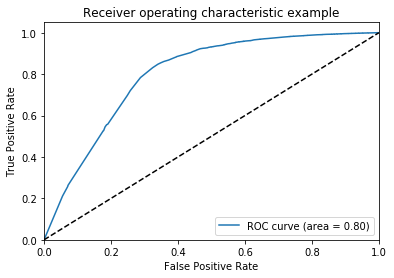

In [114]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
# Extra identificador de variables importantes
rf_model.featureImportances

In [0]:
# Diccionario de caracteristicas
training_df.schema["features"].metadata["ml_attr"]["attrs"]

## 8.3  Algoritmo de Naive Bayes

In [0]:
# Aplicacion de Algoritmo Random Fores para modelamiento de clasificacion

from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="FLAG_VENTA")
nb_model = nb.fit(training_df)

nb_prediction = nb_model.transform(test_df)

nb_prediction.select("prediction", "FLAG_VENTA", "features").show()

In [0]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = nb_prediction.select(['probability', 'FLAG_VENTA'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

In [0]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##8.4  * Algoritmo de clasificacion Support Vector Machine

In [0]:

from pyspark.ml.classification import LinearSVC

svm = NaiveBayes(labelCol="FLAG_VENTA")
svm_model = svm.fit(training_df)

svm_prediction = svm_model.transform(test_df)

svm_prediction.select("prediction", "FLAG_VENTA", "features").show()

In [0]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = svm_prediction.select(['probability', 'FLAG_VENTA'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

In [0]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 8.5 * Modelo de Red neuronal multicapa

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier


# Especificando las capas para la Red Neuronal:
# Input de las capas es de tamanio 4 (features), dos capas intermedias de tmannio 5 and 4
# y el output de salida es de tamanio 2 (classes)

#Tener mucho cuidado al definir los valores ingresados en la red neuronal!!!!!
layers = [15, 5, 4, 2]


mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, labelCol="FLAG_VENTA")
mlp_model = mlp.fit(training_df)

mlp_prediction = mlp_model.transform(test_df)


In [0]:
mlp_prediction.describe()

In [0]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = mlp_prediction.select(['probability', 'FLAG_VENTA'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

In [0]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()